In [1]:
4*3*3*2*1002

72144

In [2]:
import sys
import os
print(sys.path)
sys.path.insert(1,'../src')
from funcs_LNC import *
from processResults import *




%load_ext autoreload
%autoreload 2


['/home/emiliano/Documents/ISP/postdoc/discoveringLatentConfounders/confoundIt_py/notebooks', '/home/emiliano/anaconda3/lib/python37.zip', '/home/emiliano/anaconda3/lib/python3.7', '/home/emiliano/anaconda3/lib/python3.7/lib-dynload', '', '/home/emiliano/.local/lib/python3.7/site-packages', '/home/emiliano/anaconda3/lib/python3.7/site-packages', '/home/emiliano/anaconda3/lib/python3.7/site-packages/IPython/extensions', '/home/emiliano/.ipython']
2023-09-29 13:17:49,283:INFO:NumExpr defaulting to 8 threads.


In [3]:
import jax.numpy as np
import numpy as onp 
import pandas as pd
import pickle5 as pickle5
import pickle 
import time
import json
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import bisect
import itertools
from scipy.spatial import distance

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score

from fairlearn.reductions import ExponentiatedGradient, DemographicParity 
from sklearn.tree import DecisionTreeClassifier
from fairlearn.metrics import MetricFrame, selection_rate, count
import sklearn.metrics as skm

from sklearn.utils import check_random_state



In [4]:
import sklearn as sk
sk.__version__

'0.24.1'

In [5]:
pd.__version__

'1.3.5'

In [6]:
if not True:
    print("bla")

# Read in Experiments

In [7]:
def readGetMsrs(folder, file, job):
    if int(job) % 5000 == 0: 
        print("job: ", job)
    pathFile = folder+file+"_"+job+".pkl"
    if not os.path.isfile(pathFile):
        return None
    res = pickle5.load( open(pathFile, "rb" ) )
    n = res["Z"]["path"]["loss"].shape[0]-1
    df = {k:[res["Z"]["path"][k][n,0,0]] for k in res["Z"]["path"].keys()}
    msrs = pd.DataFrame(df)
    
    
    def convPars(x):
        if type(x) == onp.ndarray:
            res = onp.round(x, 6)[0]
        else:
            res = x
        return res

    
    parsJob = res["pars"]
    parsJob = {k: convPars(parsJob[k]) for k in parsJob.keys()}
    for k in parsJob.keys():
        msrs[k] = parsJob[k]
    
    dataInfo = res["dataInfo"]
    for k in dataInfo.keys():
        msrs[k] = dataInfo[k]

    keepMeta = ["rep","latents","confounder","proxy","dist","distsd","noise","noisesd","independent","noiseproxy","ncl","size"]
    dataInfo = res["meta"]
    for k in keepMeta:
        msrs[k] = dataInfo[k]
        
        
    
    
    return msrs

In [8]:
def get_df_fromFile(msrsFunc, folder, version, file, num_files):
    folder = folder+version+"/"
    print("folder: ", folder)


    start = time.process_time()
    msrs = [msrsFunc(folder, file,str(i+1)) for i in range(num_files)]
    print(time.process_time() - start) #15 secs
    #df = get_df(msrs, datasetTab, datsNew, pars, func_dict)
    df = pd.concat(msrs)
    return df

In [9]:
folder = "/home/emiliano/Documents/ISP/postdoc/discoveringLatentConfounders/results/"
version = "v4_lin_epchs3000_lam01_lr001_stats_all"
file = "LNC"
job = 1
num_files = 2000


In [10]:
pathFile = folder+version+"/"+file+"_"+str(job)+".pkl"
res = pickle5.load( open(pathFile, "rb" ) )
ae = res["Z"]["path"]["bias_beta"][:,:,0]
ae = pd.DataFrame(ae)
ae = ae.rename(columns={0:"bias_ce"})
ae

,bias_ce
0,0.000000
1,0.600625


In [11]:
def write_biasCE(folderRead, folderWrite, version, file, job):
    pathFile = folderRead+version+"/"+file+"_"+str(job)+".pkl"
    if not os.path.isfile(pathFile):
        print("job: ", job)
        return None
    res = pickle5.load( open(pathFile, "rb" ) )
    filenm = res["dataInfo"]["dataset"]+".csv"
    ae = res["Z"]["path"]["bias_beta"][:,:,0]
    ae = pd.DataFrame(ae)
    ae = ae.rename(columns={0:"bias_ce"})
    ae.to_csv(folderWrite+filenm)
    return filenm

def write_zc(folderRead, folderWrite, version, file, job):
    pathFile = folderRead+version+"/"+file+"_"+str(job)+".pkl"
    if not os.path.isfile(pathFile):
        print("job: ", job)
        return None
    res = pickle5.load( open(pathFile, "rb" ) )
    filenm = res["dataInfo"]["dataset"]+".csv"
    zc_df = pd.DataFrame(res["Z"]["params"]["zc"], columns=["zc"])
    zc_df.to_csv(folderWrite+filenm)
    return filenm

In [12]:
writeZs = False
writeCes = False

In [13]:
pathWrite = "/home/emiliano/Documents/ISP/postdoc/discoveringLatentConfounders/aes/aes_"+version+"/"
if writeCes: 
    filenms = [write_biasCE(folder, pathWrite, version, file, job+1) for job in range(num_files)]
    print(len(filenms))
    filenms = list(filter(lambda item: item is not None, filenms))
    print(len(filenms))
    filenms_un, indx = onp.unique(filenms, return_index=True)
    indx, = onp.where(onp.array(filenms)[-indx][0]==onp.array(filenms))
    #indx = indx+1
    print(list(indx))

In [14]:
pathWrite = "/home/emiliano/Documents/ISP/postdoc/discoveringLatentConfounders/zcs/zcs_"+version+"/"
if writeZs:
    filenms = [write_zc(folder, pathWrite, version, file, job+1) for job in range(num_files)]
    print(len(filenms))
    filenms = list(filter(lambda item: item is not None, filenms))
    print(len(filenms))
    filenms_un, indx = onp.unique(filenms, return_index=True)
    indx, = onp.where(onp.array(filenms)[-indx][0]==onp.array(filenms))
    #indx = indx+1
    print(list(indx))

In [15]:
df = get_df_fromFile(readGetMsrs, folder, version, file, num_files)

folder:  /home/emiliano/Documents/ISP/postdoc/discoveringLatentConfounders/results/v4_lin_epchs3000_lam01_lr001_stats_all/
17.047321944


In [16]:
#folder = "/home/emiliano/Documents/ISP/postdoc/discoveringLatentConfounders/results/"
#version = "v0_q30_90"
#file = "LNC"
#num_files = 2400

In [17]:
#df1 = get_df_fromFile(readGetMsrs, folder, version, file, num_files)

In [18]:
#plt.scatter(df["corr_zc"], df1["corr_zc"])

In [19]:
#indx, = onp.where(df["hsic_indep"]<df1["hsic_indep"])
#plt.scatter(df.iloc[indx]["corr_zc"], df1.iloc[indx]["corr_zc"], alpha=0.3)
#indx, = onp.where(df["hsic_indep"]>df1["hsic_indep"])
#plt.scatter(df.iloc[indx]["corr_zc"], df1.iloc[indx]["corr_zc"], alpha=0.3)

In [20]:
df.shape

(2000, 54)

In [21]:
df.head()

,loss,hsic_zx_zy,hsic_zx_zc,hsic_zy_zc,hsic_zy_x,hsic_ry_zx,hsic_indep,weight_orth,hsic_x_zc,hsic_y_zc,...,confounder,proxy,dist,distsd,noise,noisesd,independent,noiseproxy,ncl,size
0,-4.491966,0.039390,0.675500,0.499624,0.104698,0.167373,-8.364664,0.0,0.507720,0.553287,...,1,1000,exponential,1,gaussian,1.0,True,1,1,10
0,-10.767468,0.001468,0.094204,0.083043,0.062483,0.054312,-17.060459,0.0,0.299534,0.074920,...,1,1000,exponential,1,gaussian,1.0,True,1,1,100
0,-13.241296,0.000014,0.007832,0.008572,0.005228,0.006761,-31.005268,0.0,0.054326,0.082085,...,1,1000,exponential,1,gaussian,1.0,True,1,1,1000
0,-9.197082,0.003410,0.236157,0.187970,0.077125,0.072912,-13.976650,0.0,0.197389,0.200879,...,1,1000,exponential,1,gaussian,1.0,True,1,1,50
0,-13.122186,0.000080,0.022163,0.018668,0.010452,0.023988,-25.516678,0.0,0.025586,0.061566,...,1,1000,exponential,1,gaussian,1.0,True,1,1,500


In [22]:
df.columns

Index(['loss', 'hsic_zx_zy', 'hsic_zx_zc', 'hsic_zy_zc', 'hsic_zy_x',
       'hsic_ry_zx', 'hsic_indep', 'weight_orth', 'hsic_x_zc', 'hsic_y_zc',
       'hsic_xy_zc', 'mse_rx', 'mse_ry', 'mse_rx_cross', 'mse_ry_cross',
       'mses', 'stat_x', 'stat_y', 'corr_zc', 'hsic_zx', 'hsic_zy', 'hsic_zc',
       'imp_zx', 'imp_zy', 'beta_ce', 'beta_u', 'beta_x', 'bias_beta',
       'bias_beta_u', 'bias_beta_x', 'bias_beta_rel_u', 'bias_beta_rel_x',
       'lambda', 'beta', 'neta', 'nu', 'lu', 'lr', 'epchs', 'bs', 'reps',
       'dataset', 'rep', 'latents', 'confounder', 'proxy', 'dist', 'distsd',
       'noise', 'noisesd', 'independent', 'noiseproxy', 'ncl', 'size'],
      dtype='object')

In [23]:
df["size2"] = [str(sz) for sz in df["size"]]

/home/emiliano/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='corr_zc', ylabel='Density'>

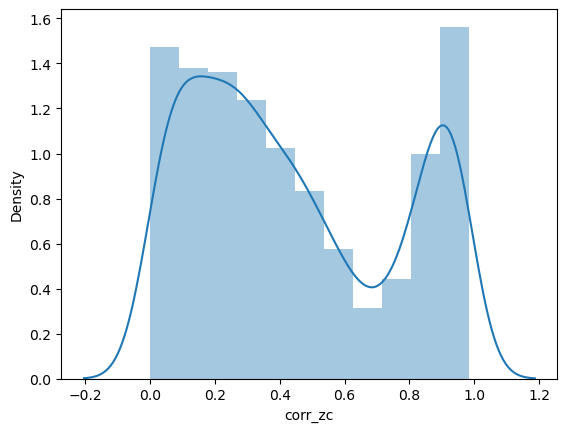

In [24]:
sns.distplot(df["corr_zc"])

In [25]:
type(df.iloc[0]["corr_zc"])

numpy.float64

/home/emiliano/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


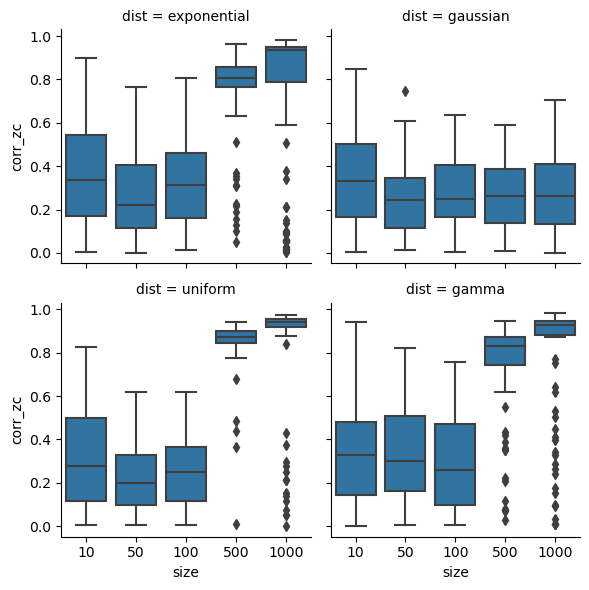

In [38]:
g = sns.FacetGrid(data=df, col="dist",col_wrap=2)
g.map(sns.boxplot,  "size", "corr_zc")

In [55]:
df["stat_y_abs"] = onp.abs(df["stat_y"])

/home/emiliano/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


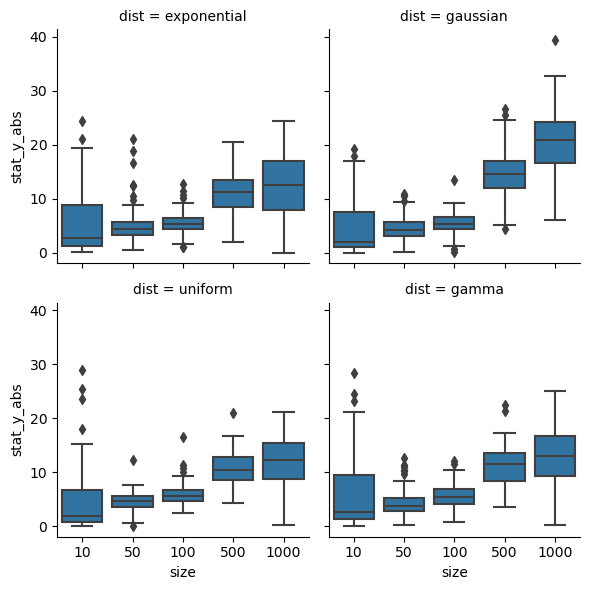

In [56]:
g = sns.FacetGrid(data=df, col="dist",col_wrap=2)
g.map(sns.boxplot,  "size", "stat_y_abs")

In [28]:
pd.concat([df, None]).shape

(2000, 55)

/home/emiliano/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


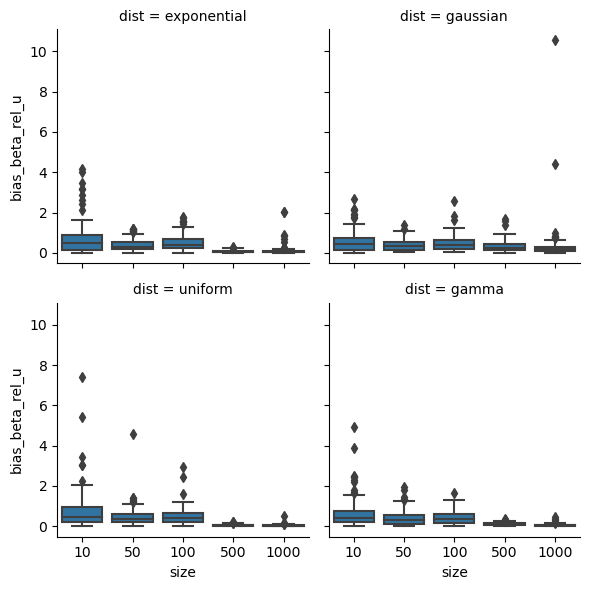

/home/emiliano/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


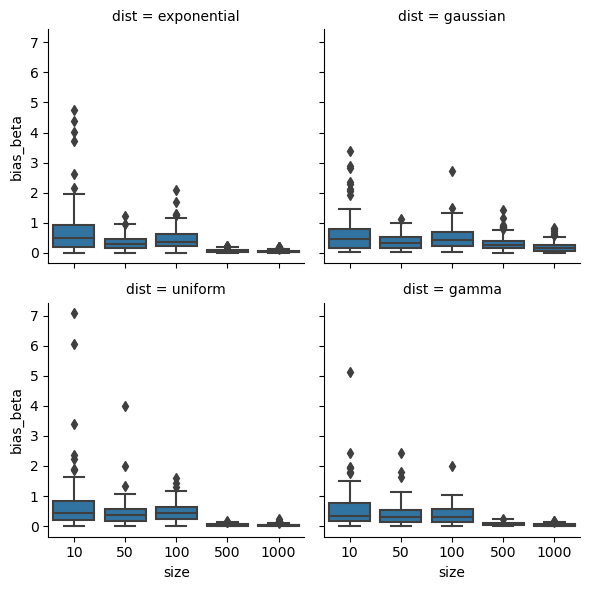

In [41]:
g = sns.FacetGrid(data=df, col="dist",col_wrap=2)
#g.map(sns.lineplot, "ln_maxPvalHsicBnch2_runMean", "value")
g.map(sns.boxplot,  "size", "bias_beta")


In [42]:
def myMed(x):
    return onp.median(x.bias_beta)
df_agg = df.groupby(["dist","size"]).apply(myMed)

In [43]:
df_agg=df_agg.reset_index().rename(columns={0:"bias_beta"})
df_agg.head()

,dist,size,bias_beta
0,exponential,10,0.476574
1,exponential,50,0.280438
2,exponential,100,0.371934
3,exponential,500,0.051858
4,exponential,1000,0.039285


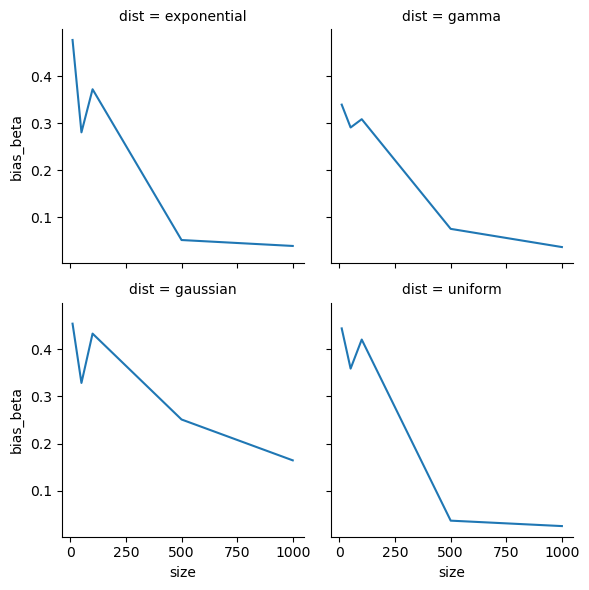

In [45]:
g = sns.FacetGrid(data=df_agg, col="dist",col_wrap=2)
#g.map(sns.lineplot, "ln_maxPvalHsicBnch2_runMean", "value")
g.map(sns.lineplot,  "size", "bias_beta")


In [46]:
df.columns

Index(['loss', 'hsic_zx_zy', 'hsic_zx_zc', 'hsic_zy_zc', 'hsic_zy_x',
       'hsic_ry_zx', 'hsic_indep', 'weight_orth', 'hsic_x_zc', 'hsic_y_zc',
       'hsic_xy_zc', 'mse_rx', 'mse_ry', 'mse_rx_cross', 'mse_ry_cross',
       'mses', 'stat_x', 'stat_y', 'corr_zc', 'hsic_zx', 'hsic_zy', 'hsic_zc',
       'imp_zx', 'imp_zy', 'beta_ce', 'beta_u', 'beta_x', 'bias_beta',
       'bias_beta_u', 'bias_beta_x', 'bias_beta_rel_u', 'bias_beta_rel_x',
       'lambda', 'beta', 'neta', 'nu', 'lu', 'lr', 'epchs', 'bs', 'reps',
       'dataset', 'rep', 'latents', 'confounder', 'proxy', 'dist', 'distsd',
       'noise', 'noisesd', 'independent', 'noiseproxy', 'ncl', 'size',
       'size2'],
      dtype='object')

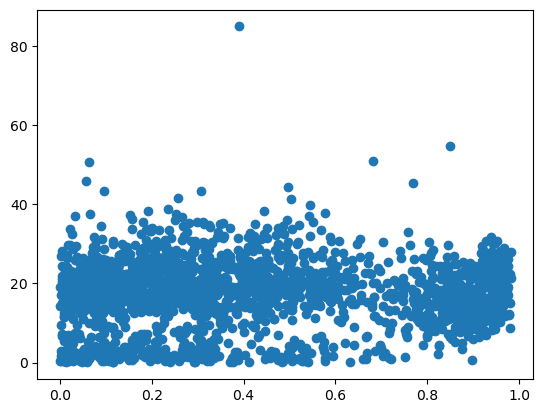

In [51]:
plt.scatter(df["corr_zc"], onp.abs(df["stat_x"]))

In [50]:
onp.corrcoef(df["corr_zc"], onp.abs(df["stat_x"])) 

array([[1.   , 0.024],
       [0.024, 1.   ]])

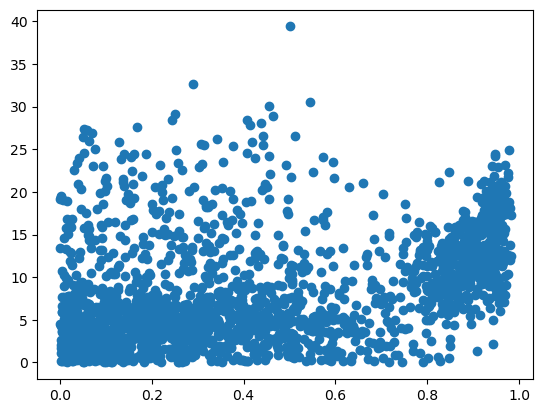

In [52]:
plt.scatter(df["corr_zc"], onp.abs(df["stat_y"]))

In [53]:
onp.corrcoef(df["corr_zc"], onp.abs(df["stat_y"]))

array([[1.  , 0.36],
       [0.36, 1.  ]])

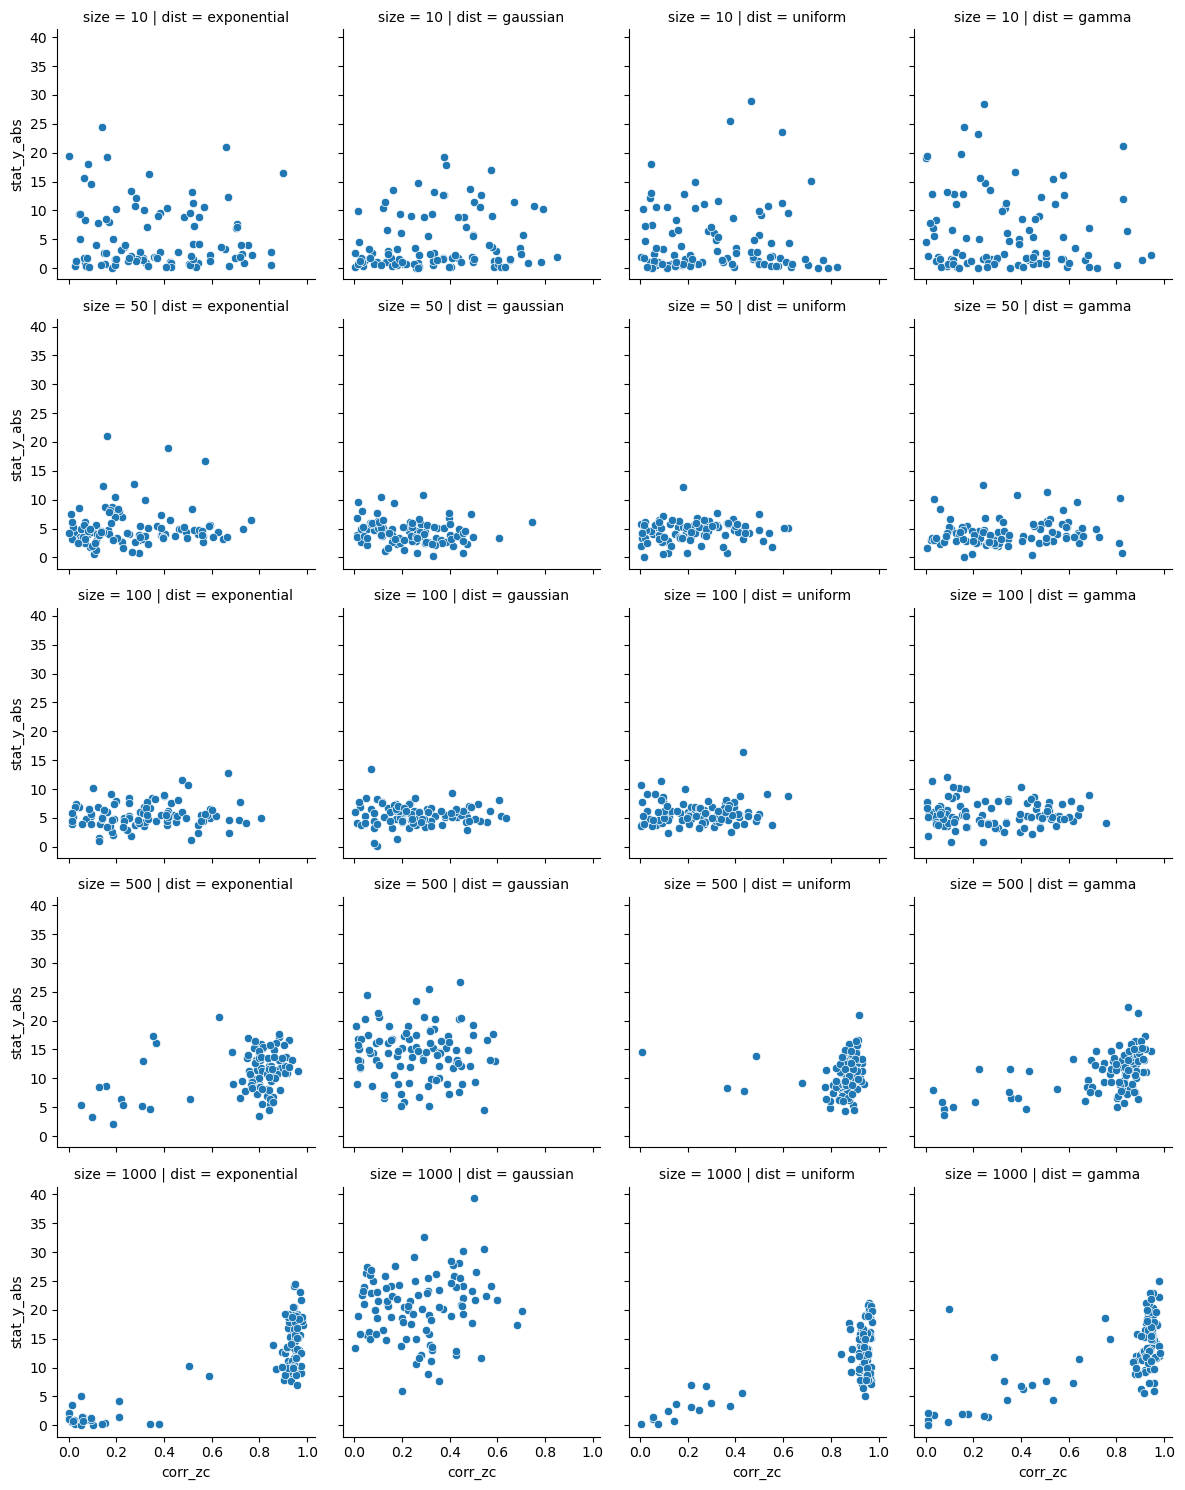

In [59]:
g = sns.FacetGrid(data=df, col="dist", row="size")
#g.map(sns.lineplot, "ln_maxPvalHsicBnch2_runMean", "value")
g.map(sns.scatterplot,  "corr_zc", "stat_y_abs")